In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as Fun
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.autograd import Variable

In [5]:
torch.manual_seed(1)
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
import torch
from torchvision import datasets, transforms

def get_data(train_batch_size, test_batch_size):

    data_transforms = transforms.Compose([
        transforms.Resize((32, 32)),  
        transforms.ToTensor(),       
        transforms.Normalize((0.1307,), (0.3081,))  
    ])

    
    training_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='./data_mnist', train=True, download=True, transform=data_transforms),
        batch_size=train_batch_size, shuffle=True)


    testing_data_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root='./data_mnist', train=False, transform=data_transforms),
        batch_size=test_batch_size, shuffle=False)

    return training_data_loader, testing_data_loader

In [11]:


class LNet(nn.Module):
    def __init__(self):
        super(LNet, self).__init__()
    
        self.layer1_conv = nn.Conv2d(1, 6, kernel_size=5)
        self.layer2_conv = nn.Conv2d(6, 16, kernel_size=5)
        self.layer3_fc = nn.Linear(16 * 5 * 5, 120)
        self.layer4_fc = nn.Linear(120, 84)
        self.output_fc = nn.Linear(84, 10)

    def forward(self, input_tensor):

        input_tensor = Fun.max_pool2d(Fun.relu(self.layer1_conv(input_tensor)), (2, 2))

        input_tensor = Fun.max_pool2d(Fun.relu(self.layer2_conv(input_tensor)), 2)

        input_tensor = input_tensor.view(-1, 16 * 5 * 5)

        input_tensor = Fun.relu(self.layer3_fc(input_tensor))
        input_tensor = Fun.relu(self.layer4_fc(input_tensor))

        input_tensor = self.output_fc(input_tensor)
        return input_tensor

    

    def num_flat_features(self, input_tensor):
        size = input_tensor.size()[1:]  
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5)
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)

        self.dense_layer1 = nn.Linear(in_features=1024, out_features=256)
        self.dense_layer2 = nn.Linear(in_features=256, out_features=10)

    def forward(self, x):
        x = Fun.relu(self.conv_layer1(x))
        x = Fun.max_pool2d(Fun.relu(self.conv_layer2(x)), kernel_size=2)
        x = Fun.dropout(x, p=0.5, training=self.training)
        x = Fun.max_pool2d(Fun.relu(self.conv_layer3(x)), kernel_size=2)
        x = Fun.dropout(x, p=0.5, training=self.training)

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.dense_layer1(x))
        x = Fun.dropout(x, p=0.5, training=self.training)
        x = self.dense_layer2(x)

        return Fun.log_softmax(x, dim=1)

In [7]:
train_batch_size = 64
test_batch_size = 1000
training_data_loader, testing_data_loader = get_data(train_batch_size, test_batch_size)

def train(model, optimizer, current_epoch, training_data_loader, logging_frequency):
    model.train()
    criterion = torch.nn.CrossEntropyLoss()
    correct_predictions = 0
    train_loss = 0
    counter = 0
    train_samples = 0

    for batch_index, (inputs, labels) in enumerate(training_data_loader):
        counter += 1
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad() 

        
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        loss.backward()  
        optimizer.step()  

        train_loss += loss.item()

        
        preds = predictions.data.max(1, keepdim=True)[1]
        train_samples += labels.size(0)
        correct_predictions += preds.eq(labels.data.view_as(preds)).sum()
        accuracy = 100.0 * correct_predictions / train_samples

        
        if batch_index % logging_frequency == 0:
            print(f'Epoch {current_epoch} [{batch_index * len(inputs)}/{len(training_data_loader.dataset)}] - Loss: {loss.item():.6f}')
            print(f"Accuracy: {accuracy:.2f}%")
    average_loss = train_loss / counter
    return average_loss, accuracy.item()

def test(model, current_epoch, testing_data_loader):
    model.eval()  
    total_test_loss = 0
    total_correct = 0
    
    
    loss_function = torch.nn.CrossEntropyLoss(reduction='sum')

    with torch.no_grad():  
        for inputs, labels in testing_data_loader:
            inputs, labels = Variable(inputs), Variable(labels)
            
            predictions = model(inputs)
            total_test_loss += loss_function(predictions, labels).item()

            
            predicted_labels = predictions.max(1, keepdim=True)[1]
            total_correct += predicted_labels.eq(labels.view_as(predicted_labels)).sum().item()

    
    average_loss = total_test_loss / len(testing_data_loader.dataset)
    accuracy_percentage = 100. * total_correct / len(testing_data_loader.dataset)

   
    print(f'\nEpoch {current_epoch}, Test Set: Average Loss: {average_loss:.4f}, '
          f'Accuracy: {total_correct}/{len(testing_data_loader.dataset)} '
          f'({accuracy_percentage:.0f}%)')

In [8]:
import torch
import torch.optim as optim


torch.manual_seed(1)


custom_model = LNet()


learning_rate = 0.01
momentum_value = 0.5


optimizer = optim.SGD(custom_model.parameters(), lr=learning_rate, momentum=momentum_value)


epoch_losses = []
epoch_accuracies = []


total_epochs = 10
logging_frequency = 200


for epoch_num in range(1, total_epochs + 1):
    epoch_loss, epoch_accuracy = train(custom_model, optimizer, epoch_num, training_data_loader, logging_frequency)
    epoch_losses.append(epoch_loss)
    epoch_accuracies.append(epoch_accuracy)
    test(custom_model, epoch_num, testing_data_loader)


Epoch 1 [0/60000] - Loss: 2.322259
Accuracy: 10.94%
Epoch 1 [12800/60000] - Loss: 0.384861
Accuracy: 46.48%
Epoch 1 [25600/60000] - Loss: 0.321628
Accuracy: 66.10%
Epoch 1 [38400/60000] - Loss: 0.259730
Accuracy: 74.59%
Epoch 1 [51200/60000] - Loss: 0.257006
Accuracy: 79.37%

Epoch 1, Test Set: Average Loss: 0.1395, Accuracy: 9572/10000 (96%)
Epoch 2 [0/60000] - Loss: 0.150828
Accuracy: 95.31%
Epoch 2 [12800/60000] - Loss: 0.078696
Accuracy: 95.48%
Epoch 2 [25600/60000] - Loss: 0.097183
Accuracy: 95.52%
Epoch 2 [38400/60000] - Loss: 0.084729
Accuracy: 95.79%
Epoch 2 [51200/60000] - Loss: 0.077683
Accuracy: 96.09%

Epoch 2, Test Set: Average Loss: 0.0937, Accuracy: 9716/10000 (97%)
Epoch 3 [0/60000] - Loss: 0.056877
Accuracy: 98.44%
Epoch 3 [12800/60000] - Loss: 0.153788
Accuracy: 97.22%
Epoch 3 [25600/60000] - Loss: 0.072354
Accuracy: 97.27%
Epoch 3 [38400/60000] - Loss: 0.120869
Accuracy: 97.38%
Epoch 3 [51200/60000] - Loss: 0.029669
Accuracy: 97.51%

Epoch 3, Test Set: Average Loss: 

In [12]:

torch.manual_seed(1)


network = CustomCNN()


learning_rate = 0.01
momentum_value = 0.5


optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum_value)


training_losses = []
training_accuracies = []


number_of_epochs = 10
update_interval = 100

for current_epoch in range(1, number_of_epochs + 1):
    epoch_loss, epoch_accuracy = train(network, optimizer, current_epoch, training_data_loader, logging_frequency=update_interval)
    training_losses.append(epoch_loss)
    training_accuracies.append(epoch_accuracy)
    test(network, current_epoch, testing_data_loader)

Epoch 1 [0/60000] - Loss: 2.325572
Accuracy: 3.12%
Epoch 1 [6400/60000] - Loss: 1.375667
Accuracy: 26.79%
Epoch 1 [12800/60000] - Loss: 0.959766
Accuracy: 47.50%
Epoch 1 [19200/60000] - Loss: 0.629025
Accuracy: 58.43%
Epoch 1 [25600/60000] - Loss: 0.394483
Accuracy: 65.04%
Epoch 1 [32000/60000] - Loss: 0.255177
Accuracy: 69.35%
Epoch 1 [38400/60000] - Loss: 0.598924
Accuracy: 72.74%
Epoch 1 [44800/60000] - Loss: 0.332482
Accuracy: 75.28%
Epoch 1 [51200/60000] - Loss: 0.279788
Accuracy: 77.27%
Epoch 1 [57600/60000] - Loss: 0.472948
Accuracy: 78.91%

Epoch 1, Test Set: Average Loss: 0.1238, Accuracy: 9619/10000 (96%)
Epoch 2 [0/60000] - Loss: 0.218585
Accuracy: 90.62%
Epoch 2 [6400/60000] - Loss: 0.119045
Accuracy: 93.13%
Epoch 2 [12800/60000] - Loss: 0.253265
Accuracy: 93.13%
Epoch 2 [19200/60000] - Loss: 0.417795
Accuracy: 93.17%
Epoch 2 [25600/60000] - Loss: 0.192971
Accuracy: 93.31%
Epoch 2 [32000/60000] - Loss: 0.079050
Accuracy: 93.45%
Epoch 2 [38400/60000] - Loss: 0.179581
Accurac

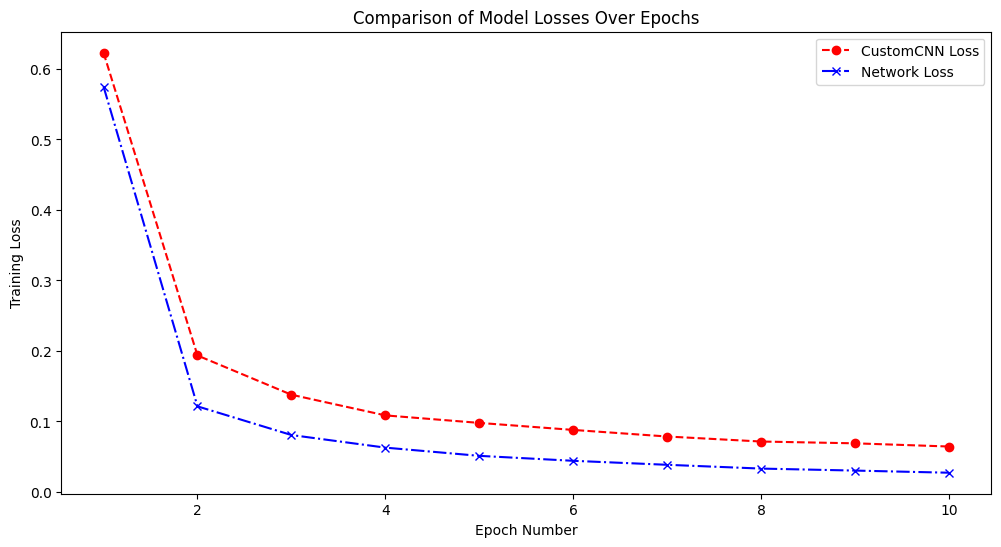

In [15]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12, 6))


plt.plot(np.arange(1, number_of_epochs + 1), training_losses, color="red", linestyle="--", marker='o')


plt.plot(np.arange(1, number_of_epochs + 1), epoch_losses, color="blue", linestyle="-.", marker='x')


plt.title('Comparison of Model Losses Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Training Loss')


plt.legend(['CustomCNN Loss', 'Network Loss'], loc='upper right')


plt.show()


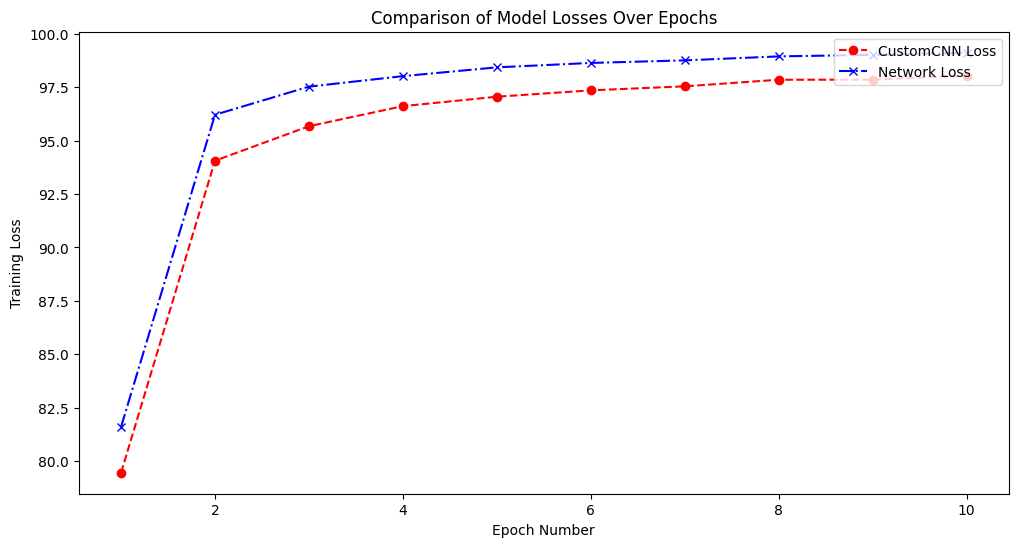

In [16]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(12, 6))


plt.plot(np.arange(1, number_of_epochs + 1), training_accuracies, color="red", linestyle="--", marker='o')


plt.plot(np.arange(1, number_of_epochs + 1), epoch_accuracies, color="blue", linestyle="-.", marker='x')


plt.title('Comparison of Model Losses Over Epochs')
plt.xlabel('Epoch Number')
plt.ylabel('Training Loss')


plt.legend(['CustomCNN Loss', 'Network Loss'], loc='upper right')


plt.show()
